In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [2]:
base_df = pd.read_excel('readyDatasets/2018-2023.xlsx')

## *Неважливо, наскільки добра буде модель - якщо дати їй неякісні дані, вона не буде працювати*

In [3]:
dataframe = base_df.copy()

cols = ['spec_num', 'Спеціальність', 'specialization']
dataframe['spec_full'] = dataframe[cols].fillna('').apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

dataframe.drop(columns=['spec_num', 'Спеціальність', 'specialization', 'Назва закладу', 'Фіксований обсяг', 'на загальних підставах', 'Усього рекомендовано'], inplace=True)

dataframe.dropna(inplace=True)

dataframe.columns = dataframe.columns.str.replace('\n', ' ')
dataframe['form'] = dataframe['form'].map({'Заочна': 0, 'Денна': 1})

У нашому датасеті є декілька категоріальних змінних: назва спеціальності органу управління, номер університету та рік. Можна було б застосувати до них метод *pandas.get_dummies()*, щоб перетворити категоріальні змінні на фіктивні змінні, які являють собою числові змінні, що використовуються для представлення категоріальних даних. Але в нашому випадку такий підхід би значно збільшив розмір датасету (аж до 416 стовпчиків), що не є дуже добре. Тому будемо застовувати так званий Target encoding, який не вимагає створення додаткових стовпчиків.                                                                                      

# Target encoding
Target encoding передбачає заміну категоріальної ознаки середнім цільовим значенням усіх точок даних, що належать до категорії. 

Однією з проблем цільового кодування є перенавчання. Деякі також називають це витоком цільової змінної в одну з фіч (Leakage of target). У цих випадках модель із цільовим кодуванням погано узагальнює нові дані. Зменшити перенавчання при цільовому кодуванні можна за допомогою згладжування.

Одним із популярних методів згладжування є використання комбінації таргету для категорії та глобального цільового середнього для кожної точки даних. Ця техніка особливо корисна для вирішення ситуацій, коли для деяких категорій дуже мало даних.

## Аддитивне згладжування
$$
\mu=\frac{n \times \bar{x}+m \times w}{n+m}
$$
де
- $\mu$ --- середнє, яке ми намагаємося обчислити (те, яке замінить наші категоріальні значення)
- $n$ --- кількість елементів у групі
- $\bar{x}$ --- передбачуване середнє
- $m$ ---ваговий коефіцієнт, який застосовується для загального середньго значення
- $w$ --- загальне середнє значення

У цій формулі $m$ є єдиним параметром, який потрібно встановити. Ідея полягає в тому, що чим вищий $m$, тим більше ми покладаємося на загальне середнє $w$. Якщо $m$ дорівнює 0, тоді отримаємо емпіричне середнє, яке дорівнює:
$$
\mu=\frac{n \times \bar{x}+0 \times w}{n+0}=\frac{n \times \bar{x}}{n}=\bar{x}
$$
Іншими словами, в такому випадку згладжування не відбувається.

Sources: стаття [Target encoding done the right way](https://maxhalford.github.io/blog/target-encoding/) та [відео пояснення](https://www.youtube.com/watch?v=Bao9GGZMLhU).

In [4]:
def calc_smooth_mean(df, by, m=5):
    # Глобальне середнє
    mean = df['УСЬОГО'].mean()

    # Обчислюємо кількість значень і середнє для кожної групи
    agg = df.groupby(by)['УСЬОГО'].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Згладжені середні
    smooth = (counts * means + m * mean) / (counts + m)

    # Замінюємо кожне значення відповідним згладженим середнім
    return df[by].map(smooth)

In [5]:
for col in ['spec_full', 'Орган управління', 'uni_code', 'Рік']:
    dataframe[col] = calc_smooth_mean(dataframe, by=col)
    
clear_df1 = dataframe.copy()

In [6]:
clear_df1 = clear_df1.reset_index().drop(columns = ['index'])

In [7]:
print(clear_df1.info())
clear_df1.head(100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20376 entries, 0 to 20375
Data columns (total 25 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   uni_code                                                  20376 non-null  float64
 1   form                                                      20376 non-null  int64  
 2   Орган управління                                          20376 non-null  float64
 3   Усього подано заяв                                        20376 non-null  int64  
 4   Подано заяв на бюджет                                     20376 non-null  int64  
 5   Допущено до конкурсу                                      20376 non-null  int64  
 6   Середній пріоритет допущених                              20376 non-null  float64
 7   Середній пріоритет рекомендованих                         20376 non-null  float64
 8   Суперобсяг      

,uni_code,form,Орган управління,Усього подано заяв,Подано заяв на бюджет,Допущено до конкурсу,Середній пріоритет допущених,Середній пріоритет рекомендованих,Суперобсяг,Рекомендовано за співбесідою,...,Сер. Бал (на загальних підставах),Макс. Бал (на загальних підставах),Рік,Макс. обсяг держзамовлення,СЕР,МІН,МАКС,Ліцензійний обсяг,Регіональний коефіцієнт,spec_full
0,10.255181,1,19.390828,373,315,310,2.954839,2.761905,525,0,...,164.857200,174.267,17.696067,21.0,144.8,113.4,190.9,50.0,1.04,15.667939
1,6.818932,1,19.390828,222,194,192,2.901042,2.000000,525,0,...,169.566000,182.564,17.696067,13.0,145.1,117.3,185.8,30.0,1.07,15.667939
2,9.035306,1,19.390828,499,435,429,3.095571,2.628571,525,0,...,170.650719,185.399,17.696067,35.0,149.5,110.8,194.2,95.0,1.00,15.667939
3,9.752988,1,19.390828,369,340,336,3.011905,1.840000,525,0,...,176.351348,194.243,17.696067,25.0,152.0,111.2,197.0,50.0,1.00,15.667939
4,6.771794,1,19.390828,208,177,173,2.716763,2.257143,525,0,...,159.607794,172.380,17.696067,35.0,144.9,111.9,192.2,50.0,1.00,15.667939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,6.771794,1,19.390828,125,111,110,2.863636,2.260870,750,0,...,174.264810,184.912,17.696067,23.0,160.9,121.3,196.8,100.0,1.00,16.293017
96,9.137534,1,19.390828,196,181,173,3.242775,2.566667,750,0,...,172.833667,180.856,17.696067,30.0,163.0,125.5,200.0,200.0,1.00,16.293017
97,14.882519,1,19.390828,413,355,352,3.448864,2.896552,750,0,...,179.447889,194.514,17.696067,29.0,159.5,118.3,196.2,180.0,1.07,16.293017
98,13.990362,1,19.390828,395,328,324,3.388889,2.095238,750,0,...,182.022077,194.087,17.696067,42.0,166.9,121.9,198.3,80.0,1.00,16.293017


<AxesSubplot:>

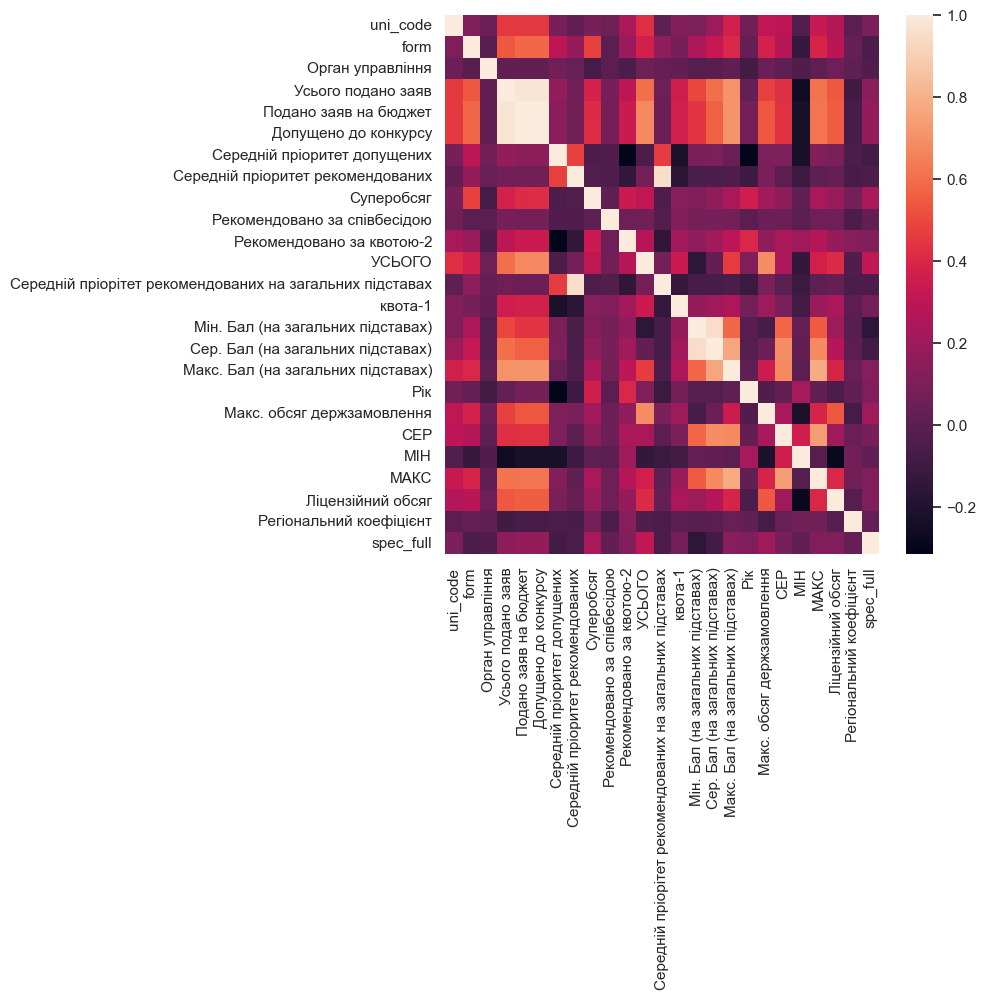

In [8]:
sns.set(rc={'figure.figsize':(7, 7)});   
sns.heatmap(clear_df1.corr(method='spearman'), xticklabels=True, yticklabels=True)

<AxesSubplot:xlabel='УСЬОГО', ylabel='Count'>

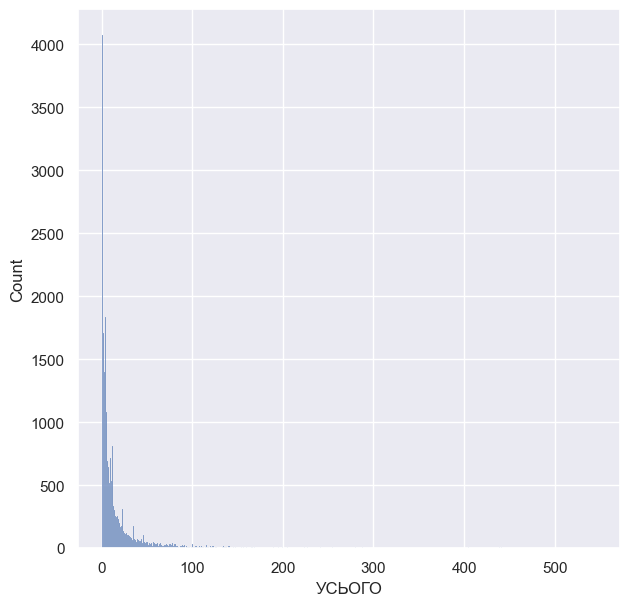

In [9]:
sns.histplot(clear_df1['УСЬОГО'])

In [11]:
from scipy.stats import normaltest
from scipy.stats import shapiro

for var in clear_df1.columns:

    p = normaltest(clear_df1[var]).pvalue
    
#   нульова гіпотеза: x походить від нормального розподілу
    alpha = 0.05
    if p > alpha:
        print('розподіл схожий на нормальний для', var)
    else:
        print('розподіл НЕ схожий на нормальний для', var)
        
#     якщо розкоментувати це, то можна побачити, що p-value завжди 0
#     print('P-value для', var, '= %.5f' % p)
        
#     також це підверджує тест Шапіро
#     print('Тест Шапіро для', var, shapiro(clear_df1[var]).pvalue)

розподіл НЕ схожий на нормальний для uni_code
розподіл НЕ схожий на нормальний для form
розподіл НЕ схожий на нормальний для Орган управління
розподіл НЕ схожий на нормальний для Усього подано заяв
розподіл НЕ схожий на нормальний для Подано заяв на бюджет
розподіл НЕ схожий на нормальний для Допущено до конкурсу
розподіл НЕ схожий на нормальний для Середній пріоритет допущених
розподіл НЕ схожий на нормальний для Середній пріоритет рекомендованих
розподіл НЕ схожий на нормальний для Суперобсяг
розподіл НЕ схожий на нормальний для Рекомендовано за співбесідою
розподіл НЕ схожий на нормальний для Рекомендовано за квотою-2
розподіл НЕ схожий на нормальний для УСЬОГО
розподіл НЕ схожий на нормальний для Середній пріорітет рекомендованих на загальних підставах
розподіл НЕ схожий на нормальний для квота-1
розподіл НЕ схожий на нормальний для Мін. Бал (на загальних підставах)
розподіл НЕ схожий на нормальний для Сер. Бал (на загальних підставах)
розподіл НЕ схожий на нормальний для Макс. Бал

Розподіл змінних далекий від нормального розподілу. Тому для визначення тiсноти зв’язку скористуємося ранговими коефiцiєнтами Спiрмена i Кендалла

УСЬОГО                                                      1.000000
Макс. обсяг держзамовлення                                  0.542016
Допущено до конкурсу                                        0.506950
Подано заяв на бюджет                                       0.506701
Усього подано заяв                                          0.446472
Макс. Бал (на загальних підставах)                          0.329120
form                                                        0.311158
uni_code                                                    0.299814
Ліцензійний обсяг                                           0.297941
квота-1                                                     0.278490
МАКС                                                        0.257080
spec_full                                                   0.218819
Рекомендовано за квотою-2                                   0.215833
Суперобсяг                                                  0.211465
СЕР                               

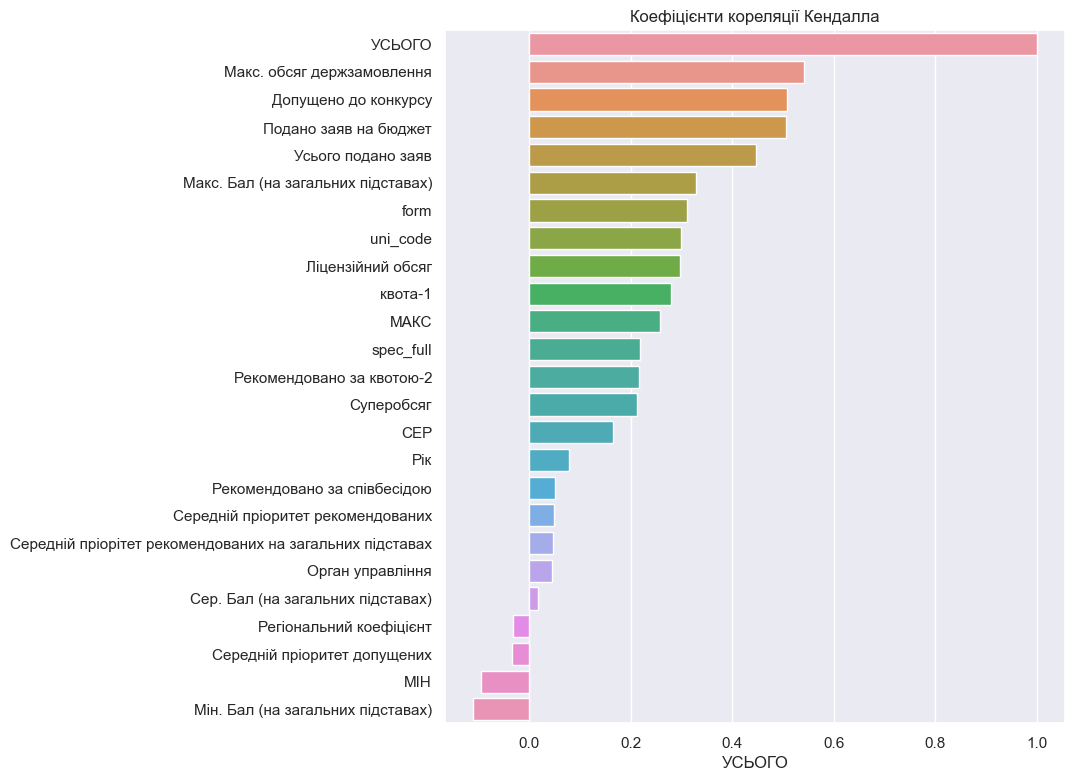

In [12]:
sns.set(rc={'figure.figsize':(8, 9)});

corr_kendall = clear_df1.corr(method='kendall')['УСЬОГО'].sort_values(ascending=False)
sns.barplot(x=corr_kendall, y=corr_kendall.index).set(title='Коефіцієнти кореляції Кендалла')
print(corr_kendall)

УСЬОГО                                                      1.000000
Макс. обсяг держзамовлення                                  0.690271
Допущено до конкурсу                                        0.672055
Подано заяв на бюджет                                       0.671505
Усього подано заяв                                          0.602191
Макс. Бал (на загальних підставах)                          0.463079
uni_code                                                    0.424142
Ліцензійний обсяг                                           0.413872
form                                                        0.372138
МАКС                                                        0.365154
квота-1                                                     0.338165
spec_full                                                   0.309695
Суперобсяг                                                  0.303935
Рекомендовано за квотою-2                                   0.267334
СЕР                               

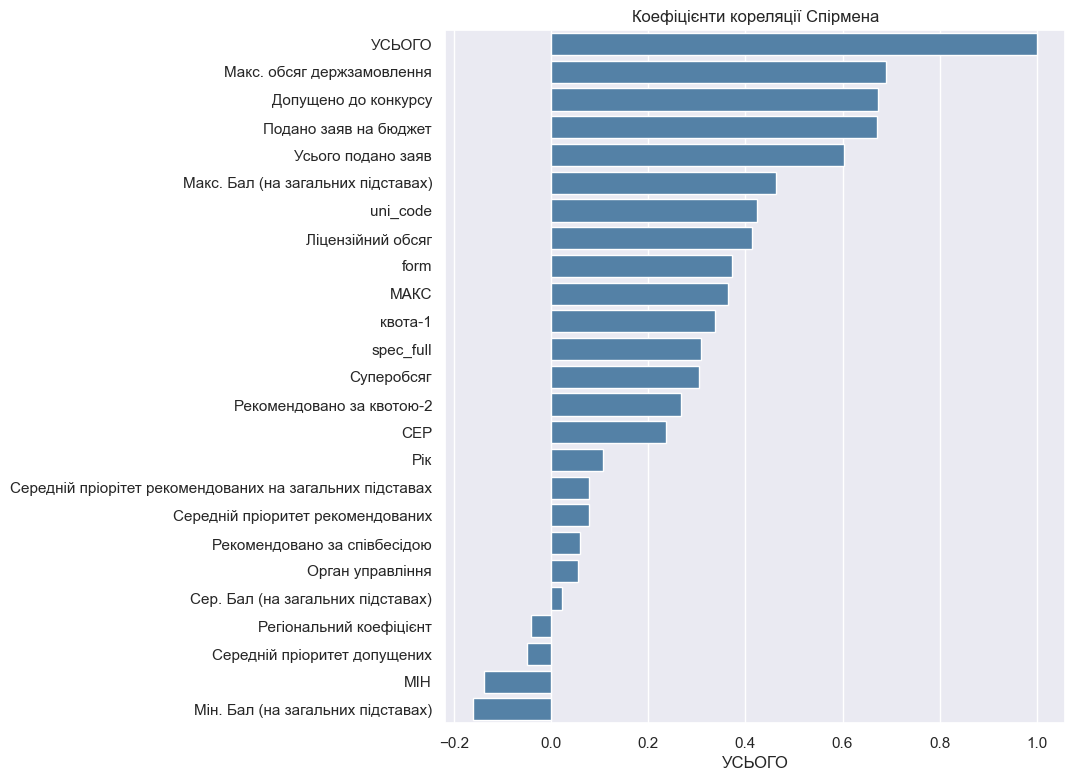

In [13]:
corr_spearman = clear_df1.corr(method='spearman')['УСЬОГО'].sort_values(ascending=False)
sns.barplot(x=corr_spearman, y=corr_spearman.index,color='steelblue').set(title='Коефіцієнти кореляції Спірмена')
print(corr_spearman)

In [14]:
print(corr_spearman.sort_index() > corr_kendall.sort_index())

form                                                         True
spec_full                                                    True
uni_code                                                     True
Допущено до конкурсу                                         True
Ліцензійний обсяг                                            True
МІН                                                         False
МАКС                                                         True
Макс. Бал (на загальних підставах)                           True
Макс. обсяг держзамовлення                                   True
Мін. Бал (на загальних підставах)                           False
Орган управління                                             True
Подано заяв на бюджет                                        True
Регіональний коефіцієнт                                     False
Рекомендовано за квотою-2                                    True
Рекомендовано за співбесідою                                 True
Рік       

Коефіцієнт Спірмена більший за коефіцієнт Кендалла майже для усіх параметрів. Це вказує на лінійну залежність між цими параметрами та цільовою змінною.

Розглянемо детальніше відношення кожної змінної до таргету.

In [15]:
corr_spearman = corr_spearman.drop(['УСЬОГО'])

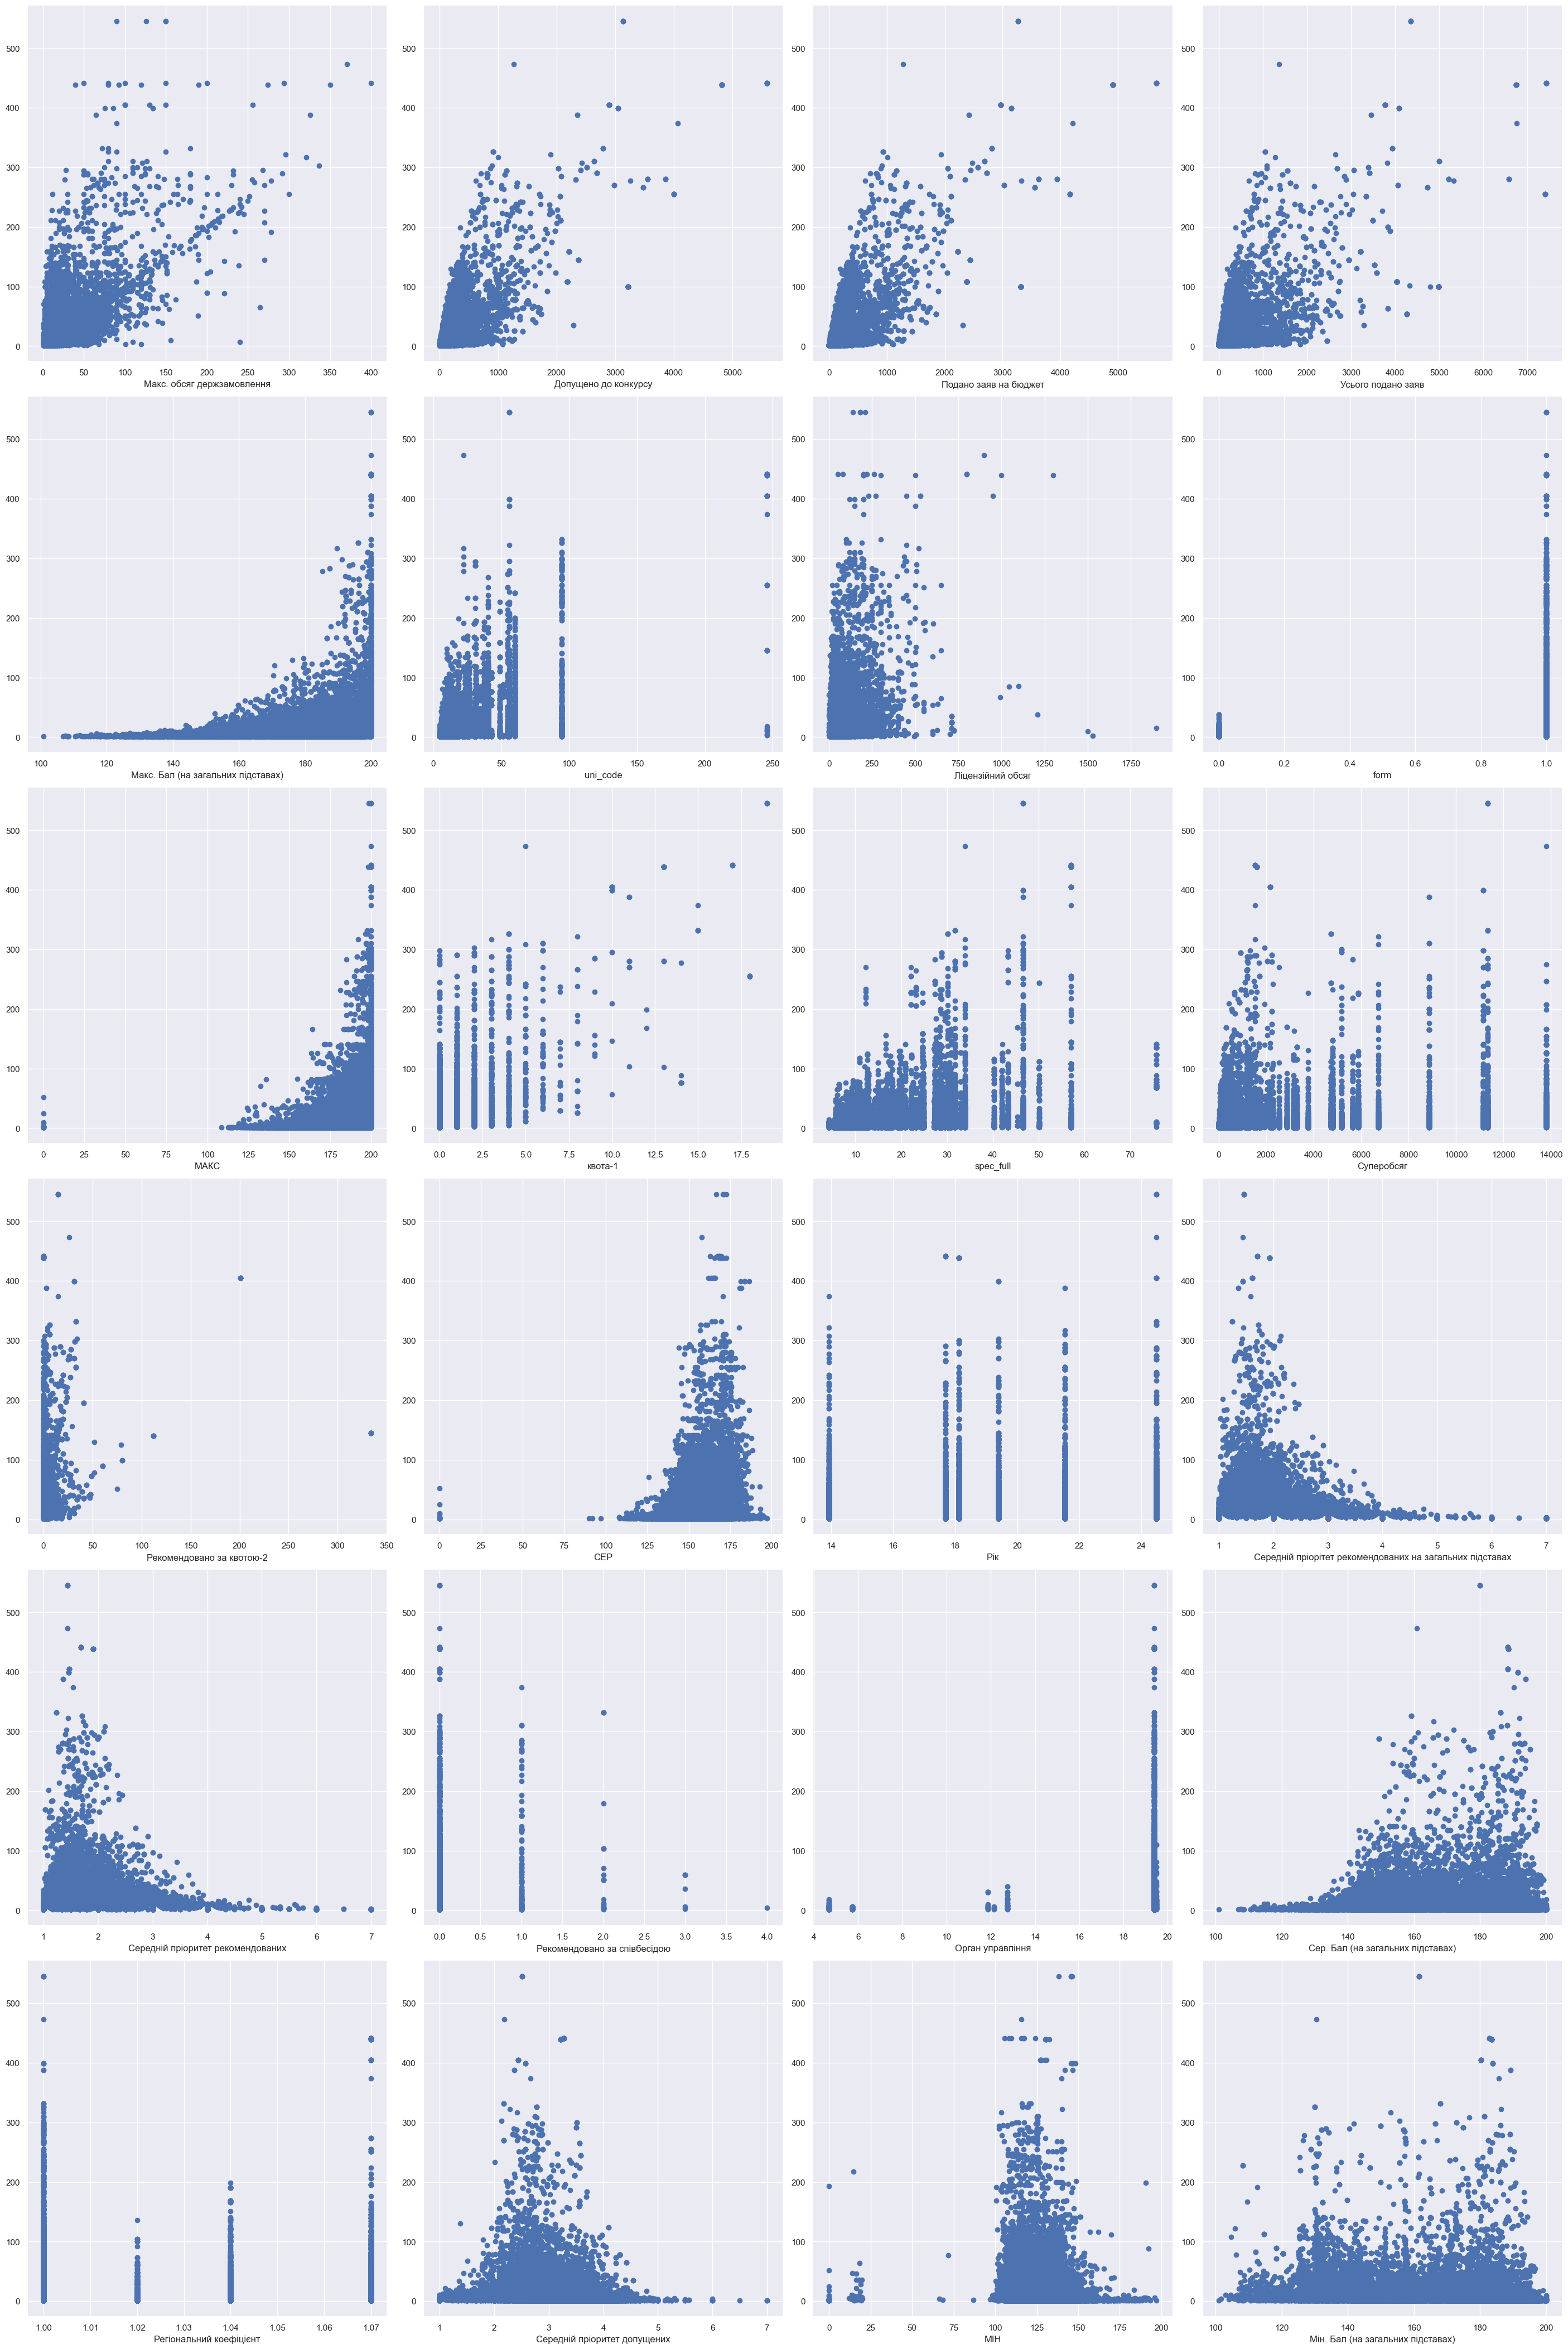

In [16]:
target= clear_df1['УСЬОГО']
num_plots = len(clear_df1.columns)
total_cols = 4
total_rows = num_plots//total_cols
fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols, figsize=(7*total_cols, 7*total_rows), constrained_layout=True)

for i, var in enumerate(corr_spearman.index):
    row = i//total_cols
    pos = i % total_cols
    axs[row][pos].scatter(clear_df1[var], target, label=var)
    axs[row][pos].set_xlabel(var)

# Коефiцiєнти еластичностi
Для визначення мiри впливу регресора на регресанд
без урахування одиниць їх вимiру використовують коефiцiєнт еластичностi.
Коефiцiєнт еластичностi показує, на скiльки вiдсоткiв змiниться регресанд, якщо
при iнших рiвних умовах $k$-й регресор збiльшити на один вiдсоток

Спочатку навчимо багатофакторну лiнiйну регресiйну модель
$$y=b_1 x_1+b_2 x_2+\ldots+b_n x_n+\varepsilon=\sum_{i=1}^n b_i x_i+\varepsilon$$
та оцінимо якість моделі за допомогою MSE (середньоквадратичної помилки):
$$ MSE  = \frac{1}{n}\sum_{i=1}^n \left(y_i - y'_i\right)^2,$$
де $y_i$ - значення цільової змінної,  $y'_i$ - передбачені моделлю значення цільової змінної.

а також коефіцієнта детермінації $R^2$.

In [17]:
X = clear_df1.drop(columns='УСЬОГО')
y = clear_df1['УСЬОГО']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

linreg = LinearRegression()

linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R2 score:", r2)

pd.DataFrame(linreg.coef_, X.columns, columns=["coef"]).sort_values(by="coef", ascending=False)

MSE: 275.7912878539227
R2 score: 0.8222631534996664


,coef
Середній пріорітет рекомендованих на загальних підставах,1.262591
Рекомендовано за співбесідою,1.081581
квота-1,1.073229
form,0.892540
Макс. обсяг держзамовлення,0.527435
Макс. Бал (на загальних підставах),0.476079
Допущено до конкурсу,0.259315
СЕР,0.200275
uni_code,0.175007
Рік,0.172404


З таблиці бачимо, що найбільший вплив на результат має показник "на загальних підставах" (оскільки має максимальне за модулем значення), наступний за ним --- кількість поданих заяв на бюджет, потім --- кількість допущених до конкурсу.

In [18]:
B = linreg.coef_
N = X.shape[1]

def getE(i):
    return B[i] * X.iloc[:, i].mean() / y.mean()

E = np.array([getE(i) for i in range(N)])

elastic_coef = pd.DataFrame(data = [E], columns = list(X.columns)).T.sort_values(by=[0], ascending=False)
elastic_coef

,0
Макс. Бал (на загальних підставах),4.433053
Допущено до конкурсу,2.152362
СЕР,1.609303
Макс. обсяг держзамовлення,0.453709
uni_code,0.176948
Рік,0.172405
Середній пріорітет рекомендованих на загальних підставах,0.128261
spec_full,0.115771
Орган управління,0.096325
Суперобсяг,0.046732


<AxesSubplot:>

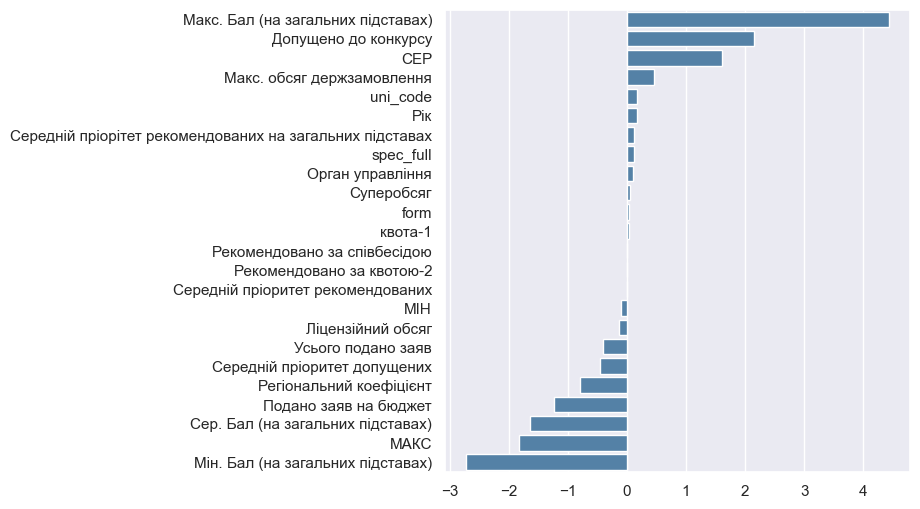

In [19]:
sns.set(rc={'figure.figsize':(6, 6)});
sns.barplot(orient = 'h', data=elastic_coef.T,color='steelblue')

# Часткові коефiцiєнти детермiнацiї
Розрахуємо ще одну ознаку впливовостi регресора у моделi --- часткові коефiцiєнти детермiнацiї. Вони показують, на яку величину зменшиться коефiцiєнт детермiнацiї, якщо якусь фічу виключити з моделi. Чим бiльший відповідний $\Delta R_k^2$, тим більш впливовим є у моделі $k$-й регресор. Частковий коефiцiєнт детермiнацiї розраховується за формулою:
$$\Delta R_k^2=\Delta R_{x_k}^2=\frac{1-R^2}{T-N}\left(\frac{\widehat{\beta}_k}{\widehat{\sigma}_{\widehat{\beta}_k}}\right)^2$$

In [20]:
def s2(y1, yh, n):
    return ((y1 - yh) ** 2).sum() / (T - n)

def s2Bk(x, y1, yh, n):
    return pd.DataFrame(np.linalg.inv(np.dot(x.T, x))) * (s2(y1, yh, n))

def dR2k(r2, t, n, b, s2bk, k):
    return (1 - r2) * ((b[k] / np.sqrt(s2bk[k][k])) ** 2) / (t - n)

yA = linreg.predict(X)
print('R2:', r2_score(y, yA))

T = clear_df1.shape[0]
N = clear_df1.shape[1]-1

coefs = []

for i in range(N):
    part_coef = dR2k(r2_score(y, yA), T, N, B, s2Bk(X, y, yA, N), i)
    coefs.append(part_coef)
    
part_coef = pd.DataFrame(coefs, X.columns, columns=["coef"]).sort_values(by="coef", ascending=False)
part_coef

R2: 0.8112247237934178


,coef
Макс. обсяг держзамовлення,4.898698e-02
Усього подано заяв,8.330619e-03
uni_code,5.188016e-03
Ліцензійний обсяг,5.057401e-03
Макс. Бал (на загальних підставах),4.791235e-03
Допущено до конкурсу,1.956863e-03
Середній пріоритет допущених,1.581942e-03
МАКС,1.569290e-03
Мін. Бал (на загальних підставах),1.361797e-03
spec_full,1.076050e-03


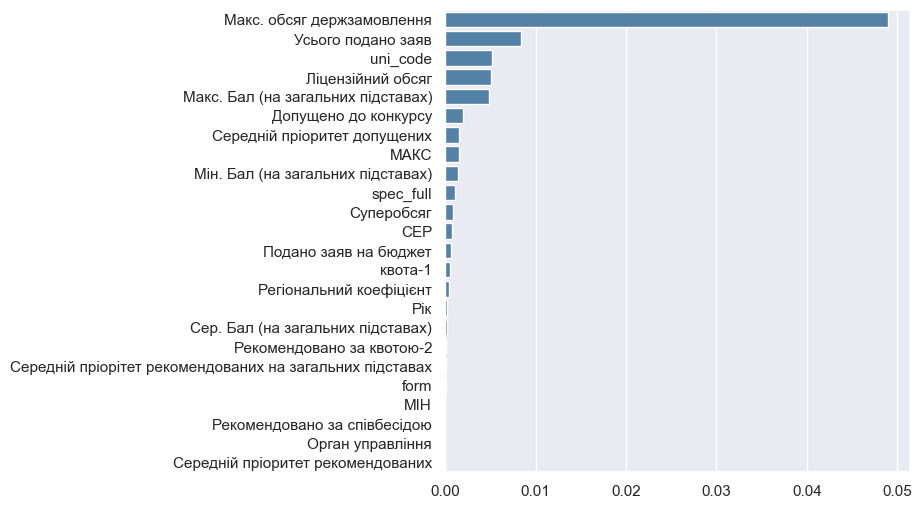

In [21]:
sns.barplot(orient = 'h', data=part_coef.T, color='steelblue')
plt.show()

# Регуляризація та відсіювання маловпливових ознак

In [22]:
lasso = Lasso()
lasso.fit(X_train, y_train)
pd.DataFrame(lasso.coef_, X.columns, columns=["coef"]).sort_values(by="coef", ascending=False)

C:\Users\natan.chachko\PycharmProjects\pythonProject\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.516e+06, tolerance: 2.147e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


,coef
Макс. обсяг держзамовлення,0.539706
Макс. Бал (на загальних підставах),0.421945
Рік,0.166420
uni_code,0.163923
СЕР,0.134497
spec_full,0.084394
Допущено до конкурсу,0.078718
Подано заяв на бюджет,0.037861
МІН,0.006977
Суперобсяг,0.000481


In [23]:
y_pred_lasso = lasso.predict(X_test)

mse = mean_squared_error(y_test, y_pred_lasso)
r2 = r2_score(y_test, y_pred_lasso)

print("MSE:", mse)
print("R2 score:", r2)

MSE: 280.0010697711238
R2 score: 0.819550111444423


Навчимо модель з L1-регуляризацією з коефіцієнтом регуляризації 0.1, 10 (слабка і сильна регуляризація), щоб вирішити проблему мультиколінеарності. Коефіцієнти при сильно скорельованих ознаках повинні бути близькі до нуля.

In [24]:
lasso_weak = Lasso(alpha=0.1)

lasso_weak.fit(X_train, y_train)

pd.DataFrame(lasso_weak.coef_, X.columns, columns=["coef"]).sort_values(by="coef", ascending=False)

C:\Users\natan.chachko\PycharmProjects\pythonProject\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.038e+06, tolerance: 2.147e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


,coef
Середній пріорітет рекомендованих на загальних підставах,0.912825
квота-1,0.870517
Макс. обсяг держзамовлення,0.531429
Макс. Бал (на загальних підставах),0.475248
СЕР,0.206477
Рік,0.188030
uni_code,0.173942
spec_full,0.090799
Допущено до конкурсу,0.082323
Подано заяв на бюджет,0.032823


In [25]:
lasso_strong = Lasso(alpha=10)

lasso_strong.fit(X_train, y_train)

pd.DataFrame(lasso_strong.coef_, X.columns, columns=["coef"]).sort_values(by="coef", ascending=False)

C:\Users\natan.chachko\PycharmProjects\pythonProject\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.960e+03, tolerance: 2.147e+03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


,coef
Макс. обсяг держзамовлення,0.522008
Макс. Бал (на загальних підставах),0.267455
uni_code,0.146196
Допущено до конкурсу,0.071267
Подано заяв на бюджет,0.048564
spec_full,0.032347
МІН,0.005072
Суперобсяг,0.000603
Середній пріоритет допущених,-0.000000
Середній пріоритет рекомендованих,-0.000000


In [26]:
alphas = np.linspace(0.1, 10, 200)
lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=17, max_iter=100000)
lasso_cv.fit(X_train, y_train)
lasso_cv.alpha_, lasso_cv.coef_

(0.1,
 array([ 1.74554910e-01,  0.00000000e+00,  5.88876518e-03, -3.14810325e-02,
        -1.38670847e-01,  2.53137698e-01, -2.42545096e+00,  0.00000000e+00,
         4.19527191e-04,  0.00000000e+00, -4.82355661e-02,  9.51578510e-01,
         9.77331405e-01, -3.29593430e-01, -1.83031848e-01,  4.76759937e-01,
         1.71836065e-01,  5.32096927e-01,  1.89326956e-01, -1.34706115e-02,
        -1.84363674e-01, -4.98319092e-02, -0.00000000e+00,  1.08057173e-01]))

In [27]:
best = np.where(lasso_cv.coef_ != 0)
print(best)
X.columns[best]

(array([ 0,  2,  3,  4,  5,  6,  8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 23], dtype=int64),)


Index(['uni_code', 'Орган управління', 'Усього подано заяв',
       'Подано заяв на бюджет', 'Допущено до конкурсу',
       'Середній пріоритет допущених', 'Суперобсяг',
       'Рекомендовано за квотою-2',
       'Середній пріорітет рекомендованих на загальних підставах', 'квота-1',
       'Мін. Бал (на загальних підставах)',
       'Сер. Бал (на загальних підставах)',
       'Макс. Бал (на загальних підставах)', 'Рік',
       'Макс. обсяг держзамовлення', 'СЕР', 'МІН', 'МАКС', 'Ліцензійний обсяг',
       'spec_full'],
      dtype='object')

In [28]:
ridge = Ridge(alpha=0.1)
ridge.fit(X_train[X.columns[best]], y_train)
pd.DataFrame(ridge.coef_, X.columns[best], columns=["coef"]).sort_values(by="coef", ascending=False)

,coef
Середній пріорітет рекомендованих на загальних підставах,1.232883
квота-1,1.082427
Макс. обсяг держзамовлення,0.530820
Макс. Бал (на загальних підставах),0.481987
Допущено до конкурсу,0.259322
СЕР,0.199922
Рік,0.175889
uni_code,0.175749
spec_full,0.109811
Орган управління,0.081145


In [29]:
y_pred_ridge = ridge.predict(X_test[X.columns[best]])
print(mean_squared_error(y_test, y_pred))

275.7912878539227


In [30]:
alphas = np.linspace(0.1, 1000, 2000)
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train[X.columns[best]], y_train)
print(ridge_cv.alpha_) 
pd.DataFrame(ridge_cv.coef_, X.columns[best], columns=["coef"]).sort_values(by="coef", ascending=False)

345.2380690345173


,coef
Середній пріорітет рекомендованих на загальних підставах,1.123559
квота-1,1.075211
Макс. обсяг держзамовлення,0.531234
Макс. Бал (на загальних підставах),0.482489
Допущено до конкурсу,0.258363
СЕР,0.198675
Рік,0.180499
uni_code,0.175351
spec_full,0.109799
Орган управління,0.077811


In [31]:
best_ridge = Ridge(alpha=ridge_cv.alpha_)
best_ridge.fit(X_train[X.columns[best]], y_train)
y_pred_ridge_b = best_ridge.predict(X_test[X.columns[best]])


y_pred_l_w = lasso_weak.predict(X_test)
y_pred_l_s = lasso_strong.predict(X_test)
y_pred = linreg.predict(X_test)

print("Weak lasso:\t MSE =", mean_squared_error(y_test, y_pred_l_w), '\t R2 =', r2_score(y_test, y_pred_l_w))
print("Ridge:\t\t MSE =", mean_squared_error(y_test, y_pred_ridge_b), '\t R2 =', r2_score(y_test, y_pred_ridge_b))
print("Linear regr:\t MSE =", mean_squared_error(y_test, y_pred), '\t R2 =', r2_score(y_test, y_pred))
print("Strong lasso:\t MSE =", mean_squared_error(y_test, y_pred_l_s), '\t R2 =', r2_score(y_test, y_pred_l_s))

Weak lasso:	 MSE = 275.43227578530554 	 R2 = 0.8224945229291656
Ridge:		 MSE = 275.9227483384114 	 R2 = 0.8221784322884409
Linear regr:	 MSE = 275.7912878539227 	 R2 = 0.8222631534996664
Strong lasso:	 MSE = 284.6567293428255 	 R2 = 0.8165497184403784


Як бачимо, Lasso і Ridge показують найкращі результати при найменьших коефіцієнтах ***a***